In [1]:
# Importamos las librerías que necesitamos

# Librerías de extracción de datos
# -----------------------------------------------------------------------

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

%load_ext autoreload
%autoreload 2

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

import sys
sys.path.append('../')
from src import funciones as f
from src import soporte_prep as sp

import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

## Población España

In [2]:
df_poblacion_es = pd.read_csv("C:\\Users\\DELL\\Downloads\\poblacion_es.csv", sep=';')

In [3]:
df_poblacion_es_filtrada = df_poblacion_es[2:24].reset_index(drop=True) # me quedo con los datos desde el 2002 hasta el 2023

In [4]:
df_poblacion_es_filtrada.to_csv('../Datos/datos_plus/poblacion_es.csv')

<Axes: xlabel='anio', ylabel='poblacion'>

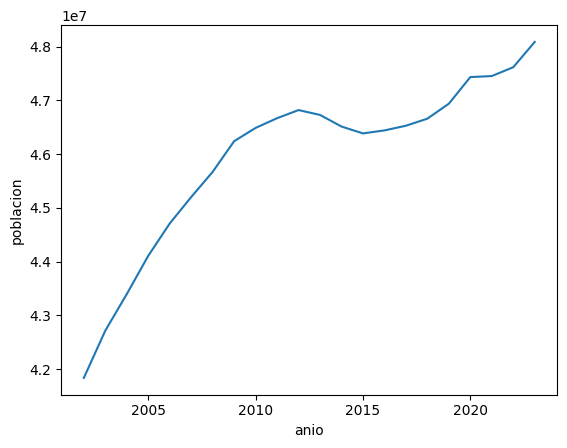

In [5]:
sns.lineplot(x='anio', y='poblacion', data=df_poblacion_es_filtrada)

## Parque Vehicular España

In [6]:
df_parque_vehicular_es = pd.read_excel("C:\\Users\\DELL\\Downloads\\Parque-de-vehiculos-Series-historicas-2023.xlsx", sheet_name='parque_ciclomotores', skiprows=2)

In [7]:
df_parque_vehicular_es.columns = ['anio', 'camiones_furgonetas', 'autobuses', 'turismos', 'motocicletas', 'tractores', 'remolques', 'otros', 'ciclomotores', 'total']

In [8]:
df_parque_vehicular_es.to_csv('../Datos/datos_plus/parque_vehicular_esp.csv')

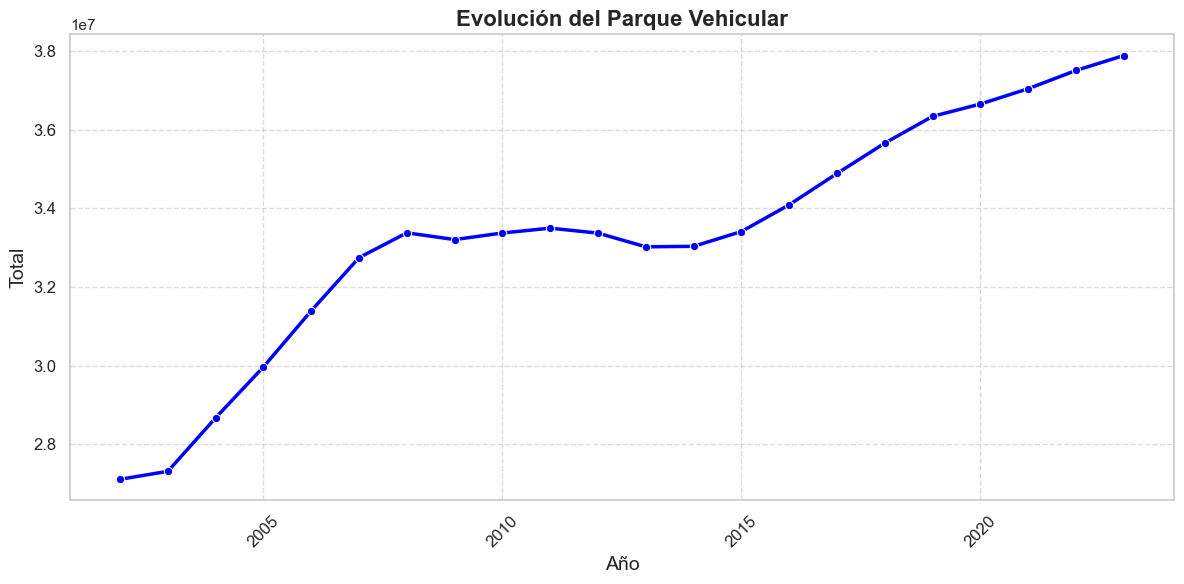

In [9]:
# Configuración general de estilo
sns.set_theme(style="whitegrid")

# Creo la visualización
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura
sns.lineplot(x='anio', y='total', data=df_parque_vehicular_es, color="blue", marker="o", linewidth=2.5)

plt.title("Evolución del Parque Vehicular", fontsize=16, fontweight='bold')
plt.xlabel("Año", fontsize=14)
plt.ylabel("Total", fontsize=14)

# Personalización de ejes
plt.xticks(fontsize=12, rotation=45)  # Girar etiquetas en el eje X si es necesario
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Evidentemente, se puede apreciar que el parque vehicular en España venía en aumento con fuerza desde principio de los 2000. Sin embargo, este proceso tuvo ciertos cambios a partir del 2008 y hasta el 2015. Durante éstos años confluyeron diversos factores que tuvieron efectos directos en el parque vehicular, cantidad y antiguedad. 
    1. Debido a la crisis económica del 2008, hubo una caída en la demanda de vehículos nuevos por lo que la compra de muchos se pospuso.
    2. El gobierno implementó el Plan 2000E, incentivando la compra de vehículos nuevos y la retirada de vehículos antiguos. Logrando elevar la entrada de vehículos.
    3. A partir del 2015, más del 75% de las fábricas españolas habían incrementado sus niveles de producción a niveles cercanos a los previos a la crisis.

- Todo esto provocó que algunos vehículos antiguos alargaran su vida útil dentro del parque vehicular. A la vez, debido a las decisiones tomadas por el gobierno para incentivar la compra de nuevos vehículos, muchos de de los vehículos desplazados fueron fueron pasados por el deshuesadero.

In [10]:
df_poblacion_es_filtrada['vehiculos'] = df_parque_vehicular_es['total']

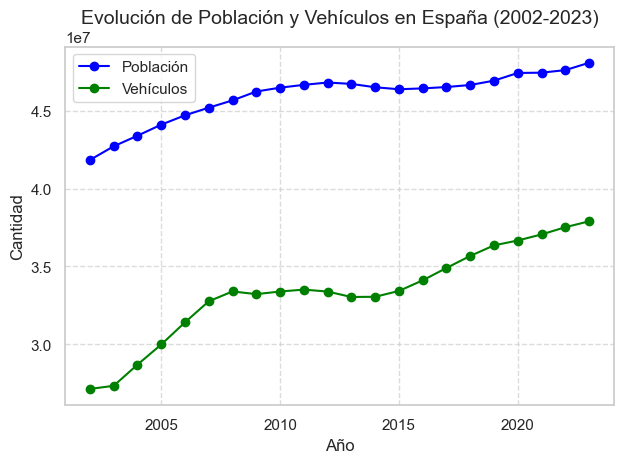

In [11]:
# Gráfica de población
plt.plot(df_poblacion_es_filtrada['anio'], df_poblacion_es_filtrada['poblacion'], marker='o', label='Población', color='blue')

# Gráfica de vehículos
plt.plot(df_poblacion_es_filtrada['anio'], df_poblacion_es_filtrada['vehiculos'], marker='o', label='Vehículos', color='green')

# Configuro el gráfico
plt.title('Evolución de Población y Vehículos en España (2002-2023)', fontsize=14)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Defunciones España

In [12]:
df_defunciones_es = pd.read_csv("C:\\Users\\DELL\\Downloads\\siniestralidad_vial_espana.csv", sep=',')

In [13]:
df_defunciones_es.columns = ['anio', 'fallecidos']

In [14]:
df_defunciones_es.to_csv('../Datos/datos_plus/defunciones_esp.csv')

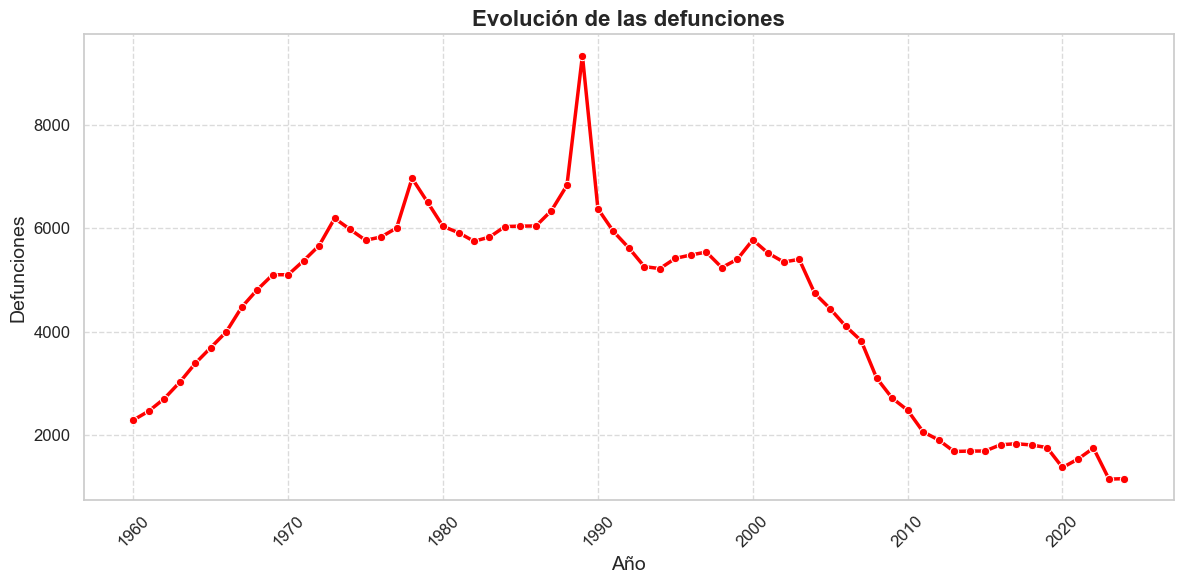

In [15]:
# Configuración general de estilo
sns.set_theme(style="whitegrid")

# Creo la visualización
plt.figure(figsize=(12, 6))  # Ajustar el tamaño de la figura
sns.lineplot(x='anio', y='fallecidos', data=df_defunciones_es, color="red", marker="o", linewidth=2.5)

plt.title("Evolución de las defunciones", fontsize=16, fontweight='bold')
plt.xlabel("Año", fontsize=14)
plt.ylabel("Defunciones", fontsize=14)

# Personalización de ejes
plt.xticks(fontsize=12, rotation=45)  # Girar etiquetas en el eje X si es necesario
plt.yticks(fontsize=12)

plt.grid(visible=True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Razones por la disminución:
- Instalación de radares fijos y de tramo para controlar los excesos de velocidad
- Límites de velocidad reducidos en zonas urbanas
- Campañas de uso obligatorio del cinturón de seguridad, evitar el uso del móvil y la concienciación sobre los riesgos del consumo de alcohol y drogas
- Modernización y mantenimiento de carreteras 
- Avances tecnológicos de los vehículos
- Aumento de controles de alcoholemia y drogas
- Implementación del sistema de puntos, desde el 2006. Incentivando comportamientos más seguros
- Multas más severas por infracciones como exceso de velocidad y uso del móvil

## Modelo para predecir y medir las diferencias entre la medida del 2006

In [16]:
df_defunciones_predecir = df_defunciones_es[(df_defunciones_es['anio'] >=2000)& (df_defunciones_es['anio'] <= 2006)]

In [17]:
df_defunciones_predecir.columns = ['ds', 'y']
df_defunciones_predecir['ds'] = pd.to_datetime(df_defunciones_predecir['ds'].astype(str) + '-12-31')

In [18]:
m = Prophet()
m.fit(df_defunciones_predecir)
future = m.make_future_dataframe(periods=2, freq='Y') 
m.predict(future)

10:39:58 - cmdstanpy - INFO - Chain [1] start processing
10:39:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-12-31,6276.03,5734.97,5814.16,6276.03,6276.03,-501.83,-501.83,-501.83,-501.83,-501.83,-501.83,0.00,0.00,0.00,5774.20
1,2001-12-31,6050.20,5475.46,5552.19,6050.20,6050.20,-537.10,-537.10,-537.10,-537.10,-537.10,-537.10,0.00,0.00,0.00,5513.10
2,2002-12-31,5824.36,5339.46,5417.28,5824.36,5824.36,-445.16,-445.16,-445.16,-445.16,-445.16,-445.16,0.00,0.00,0.00,5379.20
3,2003-12-31,5598.53,5333.01,5408.69,5598.53,5598.53,-225.99,-225.99,-225.99,-225.99,-225.99,-225.99,0.00,0.00,0.00,5372.54
4,2004-12-31,5261.02,4721.23,4795.75,5261.02,5261.02,-501.83,-501.83,-501.83,-501.83,-501.83,-501.83,0.00,0.00,0.00,4759.19
5,2005-12-31,4923.68,4344.72,4425.57,4923.68,4923.68,-537.10,-537.10,-537.10,-537.10,-537.10,-537.10,0.00,0.00,0.00,4386.58
6,2006-12-31,4586.34,4102.04,4178.13,4586.34,4586.34,-445.16,-445.16,-445.16,-445.16,-445.16,-445.16,0.00,0.00,0.00,4141.17
7,2007-12-31,4248.99,3979.39,4064.35,4233.62,4264.44,-225.99,-225.99,-225.99,-225.99,-225.99,-225.99,0.00,0.00,0.00,4023.00
8,2008-12-31,3910.73,3343.20,3466.31,3855.66,3961.54,-501.83,-501.83,-501.83,-501.83,-501.83,-501.83,0.00,0.00,0.00,3408.90


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] # predicción en los próximos 2 años (2007-2008) para comparar con la realidad

,ds,yhat,yhat_lower,yhat_upper
0,2000-12-31,5774.20,5735.44,5812.62
1,2001-12-31,5513.10,5475.17,5551.24
2,2002-12-31,5379.20,5342.15,5419.33
3,2003-12-31,5372.54,5332.83,5411.29
4,2004-12-31,4759.19,4719.65,4799.06
5,2005-12-31,4386.58,4348.47,4424.93
6,2006-12-31,4141.17,4098.75,4181.91
7,2007-12-31,4023.00,3978.37,4065.96
8,2008-12-31,3408.90,3339.64,3478.70


In [20]:
df_filtrado = df_defunciones_es[(df_defunciones_es['anio'] >= 2000) & (df_defunciones_es['anio'] <= 2010)]

In [21]:
df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] #filtro las predicciones
df['real'] = df_filtrado['fallecidos'].reset_index(drop=True) # agrego la columna real
df = df[df['real'].notnull() & df['yhat'].notnull()]
df.tail()

,ds,yhat,yhat_lower,yhat_upper,real
4,2004-12-31,4759.19,4719.65,4799.06,4741
5,2005-12-31,4386.58,4348.47,4424.93,4442
6,2006-12-31,4141.17,4098.75,4181.91,4104
7,2007-12-31,4023.00,3978.37,4065.96,3823
8,2008-12-31,3408.90,3339.64,3478.70,3100


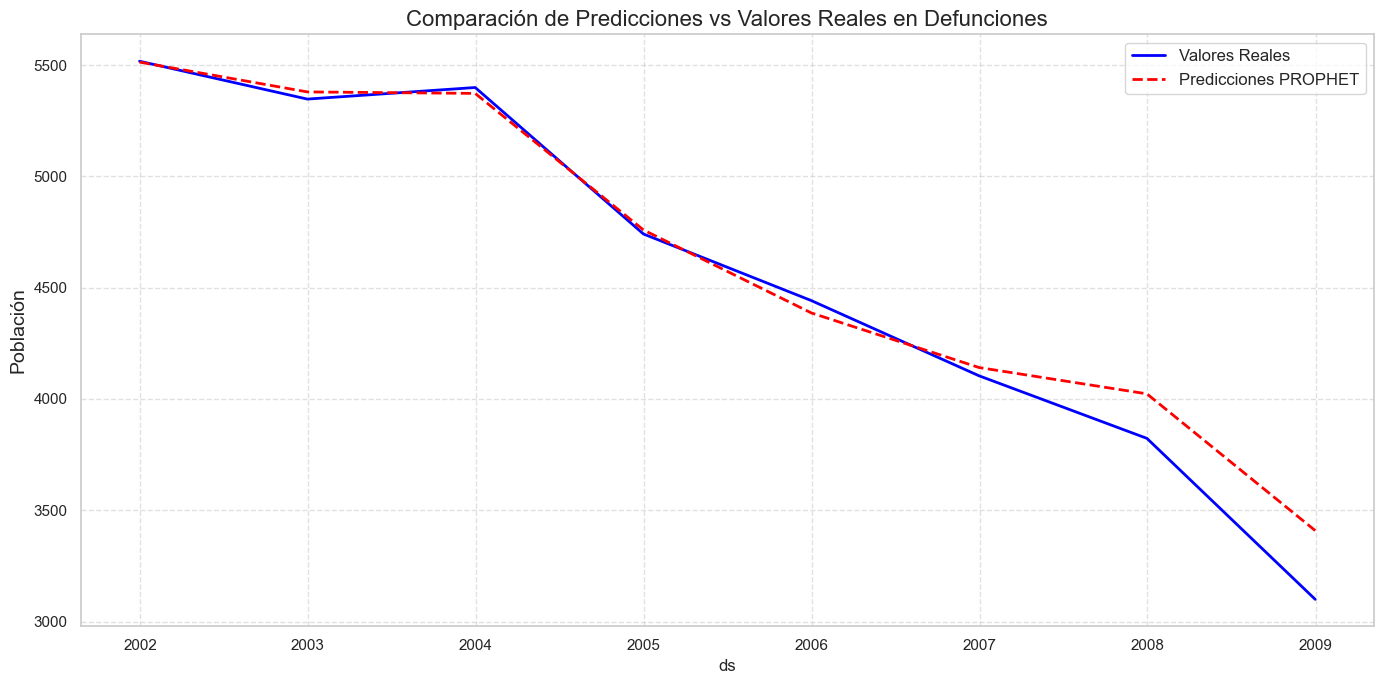

In [22]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df[1:], x="ds", y="real", label="Valores Reales", color="blue", linewidth=2) # valores reales
sns.lineplot(data=df[1:], x="ds", y="yhat", label="Predicciones PROPHET", color="red", linestyle="--", linewidth=2) # predicciones
plt.title("Comparación de Predicciones vs Valores Reales en Defunciones", fontsize=16)
plt.ylabel("Población", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6) # formato cuadriculado
plt.tight_layout()
plt.show()

In [23]:
# Selecciono las columnas relevantes
y_real = df['real']
y_pred = df['yhat']

# Cálculo de estadísticas relevantes
mae = mean_absolute_error(y_real, y_pred)
mape = mean_absolute_percentage_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))

# Imprimo los resultados
print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")               
print(f"RMSE: {rmse}")

MAE: 76.00496236453955
MAPE: 2.10%
RMSE: 125.59122256354291


Total de vidas salvadas desde 2006: 508.90


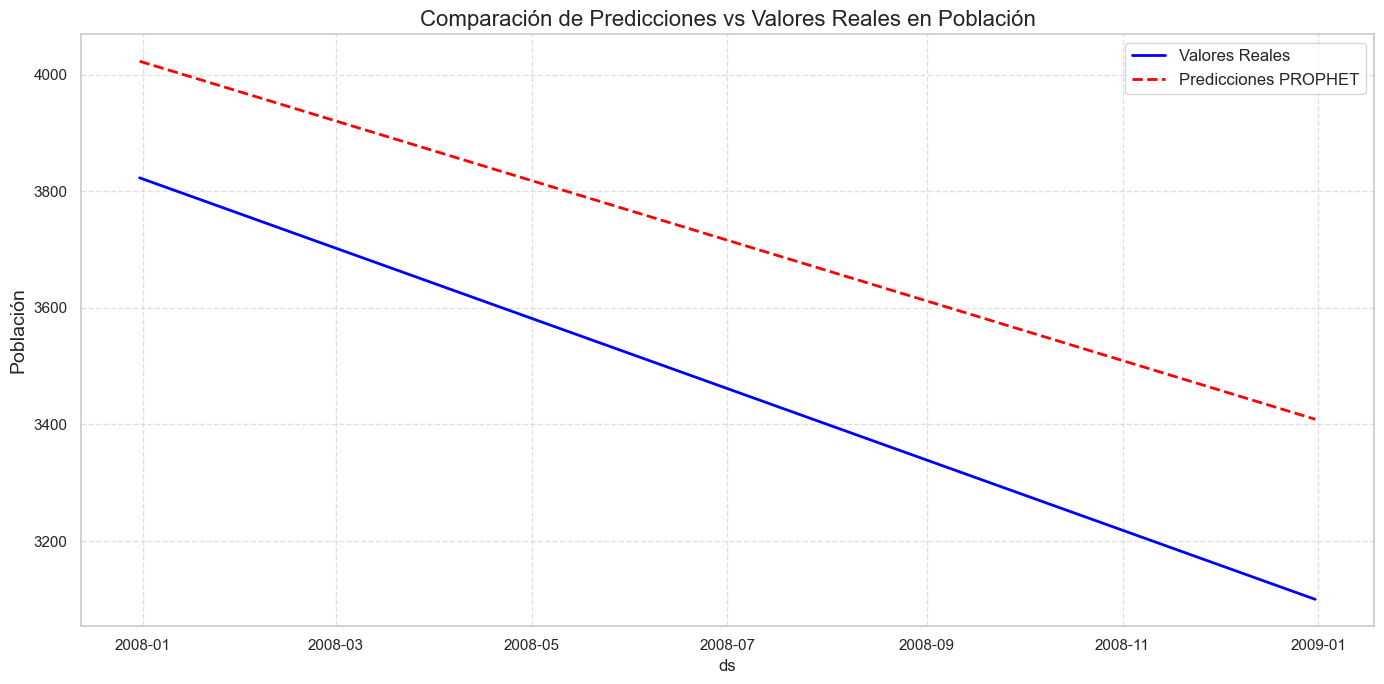

In [24]:
# Calculo vidas salvadas
df['vidas_salvadas'] = df['yhat'] - df['real']

# Filtro datos a partir de 2006
df_2006 = df[df['ds'] >= '2007-01-01']

# Calculo la suma de vidas salvadas
total_vidas_salvadas = df_2006['vidas_salvadas'].sum()

# Muestro el resultado
print(f"Total de vidas salvadas desde 2006: {total_vidas_salvadas:.2f}")

plt.figure(figsize=(14, 7))
sns.lineplot(data=df_2006, x="ds", y="real", label="Valores Reales", color="blue", linewidth=2) # valores reales
sns.lineplot(data=df_2006, x="ds", y="yhat", label="Predicciones PROPHET", color="red", linestyle="--", linewidth=2) # predicciones
plt.title("Comparación de Predicciones vs Valores Reales en Población", fontsize=16)
plt.ylabel("Población", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6) # formato cuadriculado
plt.tight_layout()
plt.show()

In [25]:
df['anio'] = df['ds'].dt.year

In [26]:
df.rename(columns={'yhat':'predicho'}, inplace=True)

In [27]:
df = df[['anio', 'predicho', 'real']]

In [28]:
# Convertir de formato wide a formato long
df_long = df.melt(id_vars=["anio"], value_vars=["predicho", "real"], 
                  var_name="tipo", value_name="valor")

# Mostrar resultado
df_long['valor'] = df_long['valor'].astype("int64")
df_long = df_long[['anio', 'valor', 'tipo']]
df_long

,anio,valor,tipo
0,2000,5774,predicho
1,2001,5513,predicho
2,2002,5379,predicho
3,2003,5372,predicho
4,2004,4759,predicho
5,2005,4386,predicho
6,2006,4141,predicho
7,2007,4023,predicho
8,2008,3408,predicho
9,2000,5776,real


In [29]:
df_long.to_csv('../Datos/datos_plus/df_comparacion_es.csv')

## Parque vehicular RD - Antiguedad

El tema de la seguridad vehicular es importantísimo para poder conseguir grandes cambios, las decisiones de las personas son claves pero si no cuentan con vehículos seguros es complicado.

- Dentro del parque vehicular dominicano, más del 40% (45.10%) de las unidades que circulan tienen más de 20 años de antiguedad. Esto no quiere decir necesariamente que los vehículos ya no son seguros, pero debido a su antiguedad algunas circunstancias los llevan a estar en desventaja en cuanto a seguridad frente a vehículos más modernos. Esto es solo describiendo el desgaste y calidad de obsoleta que pueden llegar a alcanzar algunas herramientas que garanticen la seguridad de los conductores. Si a eso se le suma falta de mantenimiento y poco cuidado por parte de los propietarios, nos encontramos frente a posibles bombas de tiempo.

Es necesario destacar que estas unidades arrojan los datos para el 2023, solo al considerar los vehículos del 2000 a años anteriores, existen más de 2 millones (MM) de unidades. Considerando que para finales del años 2024 el parque vehicular apenas superaba las 6 millones (MM) de unidades, queda clara que un tercio de las unidades presentan un peligro para sus conductores.

In [30]:
df_pvehicular_antiguo_rd = pd.read_excel('C:\\Users\\DELL\\Downloads\\ParqueVehicular2023_actualizado\\Parque_Vehicular_2023_actualizado.xlsx', sheet_name='2.9', skiprows=9, index_col=0)

In [31]:
df_pvehicular_antiguo_rd.head()

,Año de Fabricación,Tipo de Vehículo,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Participación \n%
NaN,NaN,Motocicletas,Automóviles,Jeeps,Carga,Autobuses,Máquinas Pesadas,Volteo,Otros,Total,NaN
NaN,2000a/,1169434,543088,92874,251917,54500,14427,13367,15137,2154744,0.37
NaN,2001,20720,25718,28666,15217,3154,841,743,574,95633,0.02
NaN,2002,28184,21846,29682,15021,5057,802,881,553,102026,0.02
NaN,2003,25870,18384,19059,11685,4124,428,792,415,80757,0.01


In [32]:
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd.iloc[1:, :11]
df_pvehicular_antiguo_rd.columns = ['anio', 'motocicletas', 'automóviles', 'jeeps', 'carga', 'autobuses', 'máquinas_pesadas', 'volteo', 'otros', 'total', 'participacion %']

In [33]:
df_pvehicular_antiguo_rd.reset_index(drop=True, inplace=True)
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['motocicletas'].notnull()]
df_pvehicular_antiguo_rd['participacion %'] = df_pvehicular_antiguo_rd['participacion %'] * 100

In [34]:
df_pvehicular_antiguo_rd['anio'] = df_pvehicular_antiguo_rd['anio'].apply(lambda x: x.replace('a/', '') if 'a/' in str(x) else x) # quito el elemento no deseado

In [35]:
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd[:-1]
columnas_int = df_pvehicular_antiguo_rd.columns.tolist()
df_pvehicular_antiguo_rd[columnas_int[:-1]] = df_pvehicular_antiguo_rd[columnas_int[:-1]].astype('int64')

In [36]:
# utilizo 2024 porque se consideraron los años para el 2023 con la ya llegada de vehículos de este año
año_actual = 2024 
df_pvehicular_antiguo_rd["antiguedad_promedio"] = año_actual - df_pvehicular_antiguo_rd["anio"]

# Para el año 2000 (y anteriores), ajustamos un promedio de antigüedad aproximado
df_pvehicular_antiguo_rd.loc[df_pvehicular_antiguo_rd["anio"] == 2000, "antiguedad_promedio"] = (año_actual - 2000) + 1  # Ajuste según rango histórico

# Calculo la suma ponderada de antigüedad
suma_ponderada = (df_pvehicular_antiguo_rd["antiguedad_promedio"] * df_pvehicular_antiguo_rd["total"]).sum() # tomo la antiguedad de cada año pr la cantidad de vehículos

# Calculo el promedio de antigüedad
total_vehiculos = df_pvehicular_antiguo_rd["total"].sum()
promedio_antiguedad = suma_ponderada / total_vehiculos

print(f'La antiguedad promedio del parque vehicular en el país es de {promedio_antiguedad:.2f} años para el año 2023')

La antiguedad promedio del parque vehicular en el país es de 16.11 años para el año 2023


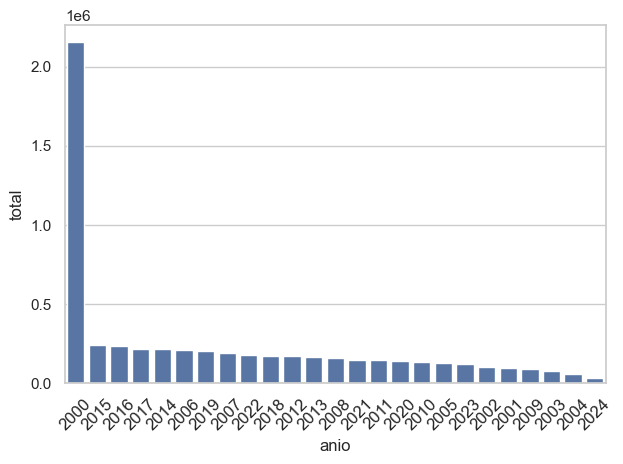

In [37]:
df_pvehicular_antiguo_rd_ordenado = df_pvehicular_antiguo_rd.sort_values(by='participacion %', ascending=False)
df_pvehicular_antiguo_rd_ordenado['anio'] = df_pvehicular_antiguo_rd_ordenado['anio'].astype(str)
sns.barplot(x='anio', y='total', data=df_pvehicular_antiguo_rd_ordenado)
plt.xticks(fontsize=12, rotation=45)
plt.tight_layout()

In [38]:
df_pvehicular_antiguo_rd = df_pvehicular_antiguo_rd.iloc[:,:-1]

In [39]:
df_pvehicular_antiguo_rd.to_csv('../Datos/datos_plus/antiguedad_pvehicular.csv')

In [40]:
df_pvehicular_antiguo_rd

,anio,motocicletas,automóviles,jeeps,carga,autobuses,máquinas_pesadas,volteo,otros,total,participacion %
0,2000,1169434,543088,92874,251917,54500,14427,13367,15137,2154744,37.09
1,2001,20720,25718,28666,15217,3154,841,743,574,95633,1.65
2,2002,28184,21846,29682,15021,5057,802,881,553,102026,1.76
3,2003,25870,18384,19059,11685,4124,428,792,415,80757,1.39
4,2004,21717,10591,16790,7063,1906,393,103,339,58902,1.01
5,2005,72314,17723,20082,13342,2542,753,706,437,127899,2.20
6,2006,147679,20719,21216,16359,2842,877,597,477,210766,3.63
7,2007,122028,23802,23944,18392,2834,879,1413,454,193746,3.34
8,2008,94859,22946,23898,12203,2857,882,955,434,159034,2.74
9,2009,44018,24024,11835,7372,1898,289,389,289,90114,1.55


In [41]:
df_pvehicular_antiguo_rd['participacion %'].sum()

100.00000000000001

In [42]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2000, 2004)]['participacion %'].sum()

42.89901286525226

Más del 40% de los vehículos de la República Dominicana a la fecha del 2023, poseen más de 20 años.

In [43]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2005, 2014)]['participacion %'].sum()

27.861647584081354

Casi un 30% de los vehículos de R.D. al 2023, poseen 10 años o más

In [44]:
df_pvehicular_antiguo_rd[df_pvehicular_antiguo_rd['anio'].between(2015, 2024)]['participacion %'].sum()

29.239339550666397

Apenas un 30% de los vehículos tienen menos de 10 años

## Vehículos por género de su propietario por propietario privado - jurídico

In [45]:
df_pveh_genero_pais = pd.read_excel('C:\\Users\\DELL\\Downloads\\ParqueVehicular2023_actualizado\\Parque_Vehicular_2023_actualizado.xlsx', sheet_name='2.5', skiprows=34, index_col=0)

In [46]:
df_pveh_genero_pais = df_pveh_genero_pais.dropna(how='all')

In [47]:
df_pveh_genero_pais = df_pveh_genero_pais.iloc[:,1:]

In [48]:
df_pveh_genero_pais.reset_index(drop=True, inplace=True)

In [49]:
df_pveh_genero_pais['Tipo'] = df_pveh_genero_pais['Tipo'].str.replace(r'\d+/.*', '', regex=True).str.strip()

In [50]:
df_pveh_genero_pais.columns = ['tipo', 'femenino', 'masculino', 'persona_juridica', 'total']

In [51]:
columnas_int = df_pveh_genero_pais.columns.tolist()[1:5]

In [52]:
df_pveh_genero_pais[columnas_int] = df_pveh_genero_pais[columnas_int].astype(int)

In [53]:
df_pveh_genero_pais = df_pveh_genero_pais.T[1:]
df_pveh_genero_pais.reset_index(inplace=True)
df_pveh_genero_pais.columns = ['propietario','motocicletas', 'automoviles', 'jeep', 'carga', 'autobuses', 'maquinas_pesadas', 'volteo', 'otros', 'total']
df_pveh_genero_pais = df_pveh_genero_pais[:-1]

In [54]:
total_sumado = df_pveh_genero_pais['total'].sum()

df_pveh_genero_pais['porcentaje'] = (df_pveh_genero_pais['total'] / total_sumado) * 100

df_pveh_genero_pais


,propietario,motocicletas,automoviles,jeep,carga,autobuses,maquinas_pesadas,volteo,otros,total,porcentaje
0,femenino,409366,302004,226030,40868,18407,1236,1747,960,1000621,17.22
1,masculino,1831636,693452,391888,297820,75209,10575,12692,7760,3321036,57.17
2,persona_juridica,1039644,126238,60112,182378,37017,15755,11094,15241,1487479,25.61


Anotaciones:
    - A resaltar, más del 50% de los vehículos registrados para el 2023 corresponden a hombres. Una cuarta parte, corresponde a personas jurídicas (25.61%) mientras que menos del 20% (17.22%) corresponde a mujeres. 
Esto puede tener sentido considerando que la gran masa de conductores que salen a la calle a trabajar resulta que son hombres, tanto aquellos que utilizan sus medios solo para transporte como aquellos que usan su vehículo como modo de trabajo personal (taxistas, repartidores, etc). Sin embargo, esto puede dejar de lado algunos casos donde los hombres otorgan vehículos a mujeres para ser conducidos por ellas pero se mantienen bajo el registro del hombre.

In [55]:
df_pveh_genero_pais.to_csv('../Datos/datos_plus/parquev_privado_publico.csv')

## Vehículos por género de su propietario por provincia

In [56]:
df_pveh_genero_rd_prov = pd.read_excel('C:\\Users\\DELL\\Downloads\\ParqueVehicular2023_actualizado\\Parque_Vehicular_2023_actualizado.xlsx', sheet_name='2.6', skiprows=7, index_col=0)

In [57]:
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov[['Provincia', 'Género', 'Unnamed: 4', 'Total', 'Género.1', 'Unnamed: 11', 'Total.1']]

In [58]:
df_pveh_genero_rd_prov.columns = ['provincia', 'femenino', 'masculino', 'total', '%_fem', '%_masc', 'total_%']
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov.iloc[1:]
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov[df_pveh_genero_rd_prov['femenino'].notnull()]

In [59]:
df_pveh_genero_rd_prov.reset_index(drop=True, inplace=True)

In [60]:
df_pveh_genero_rd_prov['total'] = df_pveh_genero_rd_prov['total'].astype(int)

In [61]:
df_pveh_genero_rd_prov_copia = df_pveh_genero_rd_prov.copy()
df_pveh_genero_rd_prov = df_pveh_genero_rd_prov[['provincia', 'femenino', 'masculino', 'total']]

In [62]:
df_pveh_genero_rd_prov.to_csv('../Datos/datos_plus/parquev_genero_prov.csv')

In [63]:
df_pveh_genero_rd_prov_copia

,provincia,femenino,masculino,total,%_fem,%_masc,total_%
0,Azua,11622,53345,64967,0.18,0.82,1.00
1,Bahoruco,3124,11835,14959,0.21,0.79,1.00
2,Barahona,10375,39892,50267,0.21,0.79,1.00
3,Dajabón,5928,16559,22487,0.26,0.74,1.00
4,Distrito Nacional,247292.26,903760.42,1151052,0.21,0.79,1.00
5,Duarte,32052,101064,133116,0.24,0.76,1.00
6,El Seibo,6853,18539,25392,0.27,0.73,1.00
7,Elías Piña,1450,5778,7228,0.20,0.80,1.00
8,Espaillat,24541,89690,114231,0.21,0.79,1.00
9,Hato Mayor,7728,19508,27236,0.28,0.72,1.00


In [64]:
min_valor_masc = df_pveh_genero_rd_prov_copia['%_masc'].min()
fila_masc = df_pveh_genero_rd_prov_copia[df_pveh_genero_rd_prov_copia['%_masc'] == min_valor_masc]
fila_masc

,provincia,femenino,masculino,total,%_fem,%_masc,total_%
9,Hato Mayor,7728,19508,27236,0.28,0.72,1.00


In [65]:
min_valor_fem = df_pveh_genero_rd_prov_copia['%_fem'].min()
fila_fem = df_pveh_genero_rd_prov_copia[df_pveh_genero_rd_prov_copia['%_fem'] == min_valor_fem]
fila_fem

,provincia,femenino,masculino,total,%_fem,%_masc,total_%
0,Azua,11622,53345,64967,0.18,0.82,1.00


En todas las provincias, los hombres tienen más del 70% de los vehículos. Resaltando como mínimo la provincia de Hato Mayor con un 72% de los vehículos perteneciente al sexo masculino. En el caso contrario, la provincia con menor presencia de posesión de vehículos de parte del género femenino es Azua, donde no supera el 20% de los vehículos.

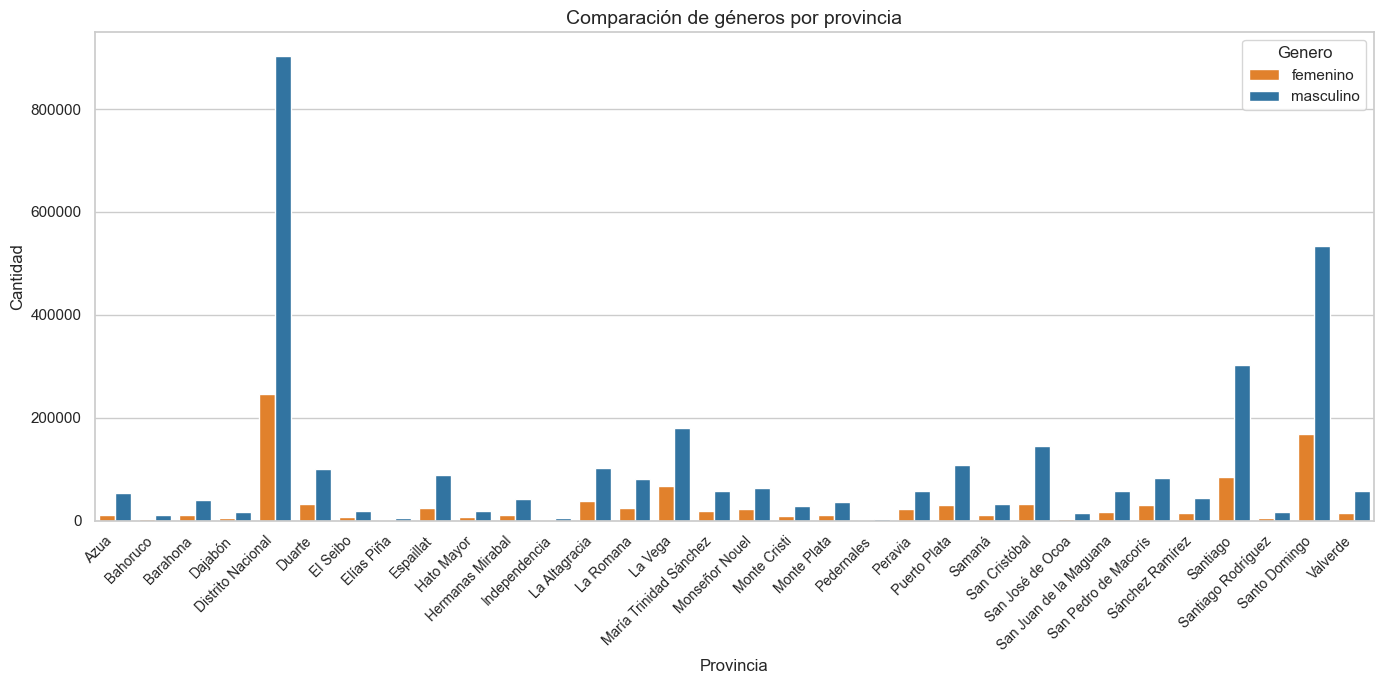

In [66]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(14, 7))

# Creo un gráfico de barras agrupadas
df_long = df_pveh_genero_rd_prov_copia.iloc[:-1][['provincia', 'femenino', 'masculino']].melt(id_vars='provincia', var_name='Genero', value_name='Cantidad')
sns.barplot(x='provincia', y='Cantidad', hue='Genero', data=df_long, palette={'femenino': '#ff7f0e', 'masculino': '#1f77b4'})

# Ajusto el eje X para que las etiquetas sean legibles
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Cantidad', fontsize=12)
plt.xlabel('Provincia', fontsize=12)
plt.title('Comparación de géneros por provincia', fontsize=14)

plt.tight_layout()
plt.show()


## Infracciones de tránsito

- Infracciones 2010 - 2017: durante este periodo de tiempo, las infracciones fueron distribuidas en 10 categorías distintas. Las más presentes, con más de un 10% de aparición durante estos años son: transitar sin casco, via contraria, violar la luz roja y transitar sin cinturón. Solo en esas 4 categorías se agrupa más del 50% de las infracciones en este periodo de años, lo que indica que el comportamiento de los conductores no está alineado a su propia autoconservación. La falta de estas 4 cosas pone en total peligro a quienes conducen. sin dejar de lado que en las demás infracciones también aparecen "hablar por el teléfono celular" y "giro prohibido", las cuáles también atentan contra la integridad de la persona.

La presencia de estas, primordialmente se mantiene en grandes números en los años ya mencionados. Puede que en algún año disminuya, pero en otros aumenta más de lo que normalmente acostumbra. Sin embargo, su presencia es notable. 

- Infracciones 2018 - 2024: durante esos años, el número general de infracciones se eleva bastante. Esto llegando a superar las 2 millones (MM) de infracciones. Este número venía en aumento desde el 2018 pero se vio reducido durante la pandemia. No será hasta el 2022 cuando se consigue superar este número, considerando que apenas 2 años después del periodo anterior se superó la unidad de millón (MM) de infracciones. Para después del 2022, se se un descenso que luego vuelve a aumentar para el año anterior (2024).

Se debe resaltar que en estos años, la introducción de distintas infracciones en el registro puede que haya aumentado el número de estas. Llegando a tener hasta 100 tipos de infracciones distintas, es lógico que el número pueda verse aumentado. Sin embargo, aquellas que ponen en peligro a los conductores siguen liderando los números de presencialidad. Llegando a registrarse más de medio millón de infracciones con relación al "no uso del caso protector". Lo cuál puede parecer una locura, queda claro que es preocupante pero a la ez preocupa que cada año al menos 180 mil infracciones sean por no usar el casco protector.

In [67]:
df_infracciones_1 = pd.read_excel("C:\\Users\\DELL\\Downloads\\Infracciones de Tránsito, DIGESETT, 2010 - 2017.xlsx")
df_infracciones_2 = pd.read_excel("C:\\Users\\DELL\\Downloads\\Infracciones de Tránsito, DIGESETT, 2018 - 2024.xlsx")

In [68]:
df_infracciones_1.columns = ['infracciones', 'total', 'anio']
df_infracciones_2.columns = df_infracciones_2.columns.str.lower()
df_infracciones_2.rename(columns={'año':'anio'}, inplace=True)

In [69]:
df_infracciones_2['total'] = df_infracciones_2.iloc[:,1:13].sum(axis=1)

In [70]:
df_infracciones_2.reset_index(drop=True, inplace=True)

In [71]:
df_infracciones_2.columns = df_infracciones_2.columns.str.strip()

### Primer grupo de años 2010 - 2017

<Axes: xlabel='anio', ylabel='total'>

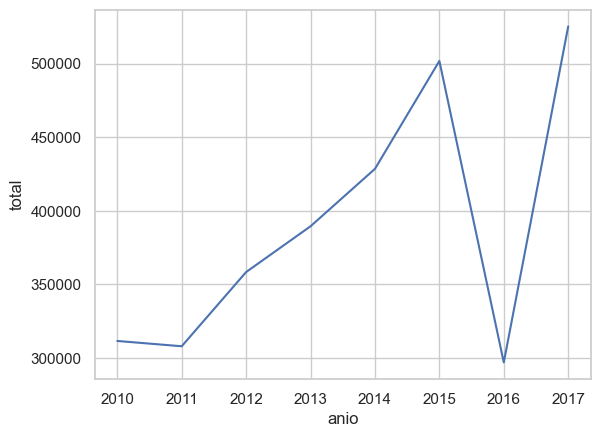

In [72]:
total_infraciones_1 = df_infracciones_1.groupby('anio')['total'].sum().reset_index()
sns.lineplot(x='anio', y='total', data=total_infraciones_1)

In [73]:
df_infracciones_1['infracciones'] = df_infracciones_1['infracciones'].replace({
    'TRANSITAR EN VIA CONTRARIA': 'VIA CONTRARIA'
})

In [74]:
# Calcular el porcentaje dentro de cada año usando transform
df_infracciones_1['porcentaje'] = df_infracciones_1.groupby('anio')['total'].transform(lambda x: (x / x.sum()) * 100)

In [75]:
pivot_infracciones_1 = f.crear_tabla_pivote(df_infracciones_1, values='total', index='infracciones', columns='anio', aggfunc='sum')
pivot_infracciones_1['total'] = pivot_infracciones_1.sum(axis=1)

In [76]:
pivot_infracciones_1.reset_index(inplace=True)

In [77]:
total_pivot = pivot_infracciones_1['total'].sum()
pivot_infracciones_1['porcentaje'] = (pivot_infracciones_1['total']/total_pivot) * 100
pivot_infracciones_1.sort_values(by='porcentaje', ascending=False)

anio,infracciones,2010,2011,2012,2013,2014,2015,2016,2017,total,porcentaje
6,TRANSITAR SIN CASCO,45466,20561,23871,64290,67628,122494,70808,140033,555151,17.80
8,VIA CONTRARIA,55310,53101,51988,65422,56187,62654,44510,80072,469244,15.04
9,VIOLAR LA LUZ ROJA,31531,43938,57284,43929,66462,71981,43917,62897,421939,13.53
7,TRANSITAR SIN CINTURON,31331,42142,61606,54102,65821,62345,32709,53885,403941,12.95
5,OBSTRUIR EL TRANSITO,24540,15768,40655,44210,50948,48598,21893,45556,292168,9.37
3,HABLAR POR CELULAR,29876,32657,37324,28247,27898,34567,18765,29034,238368,7.64
0,CONDUCIR SIN LICENCIA,30342,31779,27657,27657,32546,40032,17656,29446,237115,7.60
1,ESTACIONARSE EN LUGARES PROHIBIDO,17564,21372,15676,14345,21334,20145,25694,51302,187432,6.01
2,GIRO PROHIBIDO,19574,30733,23453,24536,17869,18493,10323,16702,161683,5.18
4,LICENCIA VENCIDA,25880,15765,18756,22647,21736,20463,10536,16306,152089,4.88


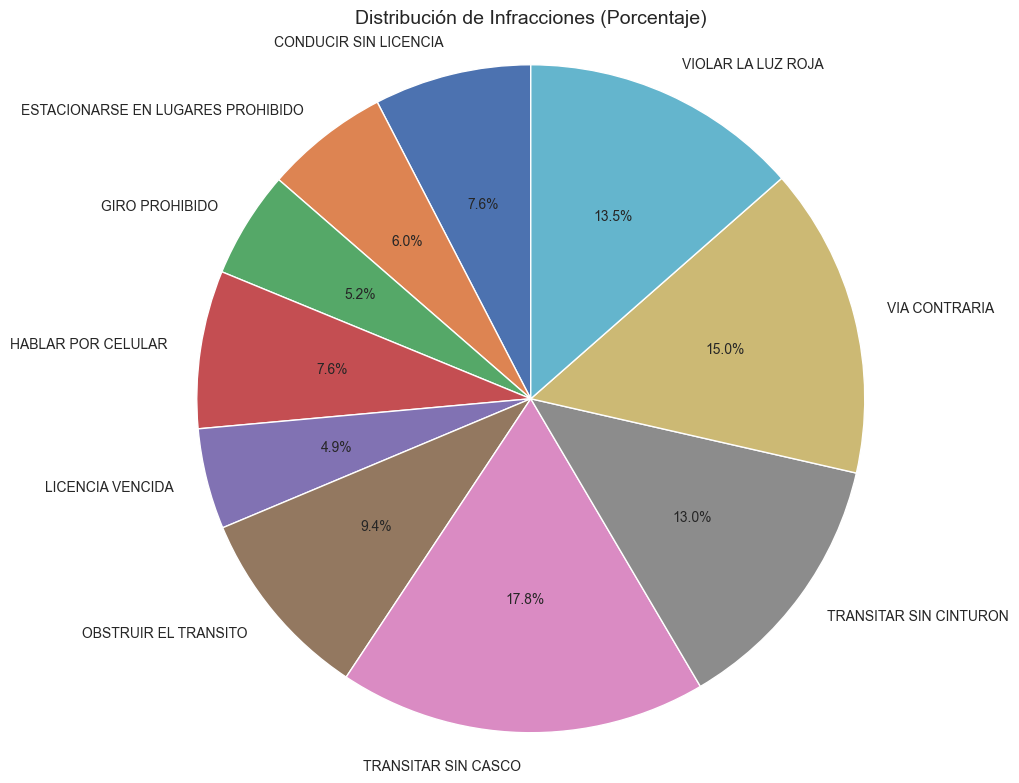

In [78]:
# Filtro los datos necesarios (solo columnas 'infracciones' y 'porcentaje')
infracciones = pivot_infracciones_1['infracciones']
porcentajes = pivot_infracciones_1['porcentaje']

# Creo el gráfico de pastel
plt.figure(figsize=(10, 8))
plt.pie(
    porcentajes, 
    labels=infracciones, 
    autopct='%1.1f%%', 
    startangle=90,
    textprops={'fontsize': 10}  # Tamaño de las etiquetas
)

plt.title('Distribución de Infracciones (Porcentaje)', fontsize=14)
plt.axis('equal')  # Para que el gráfico sea un círculo
plt.tight_layout()
plt.show()


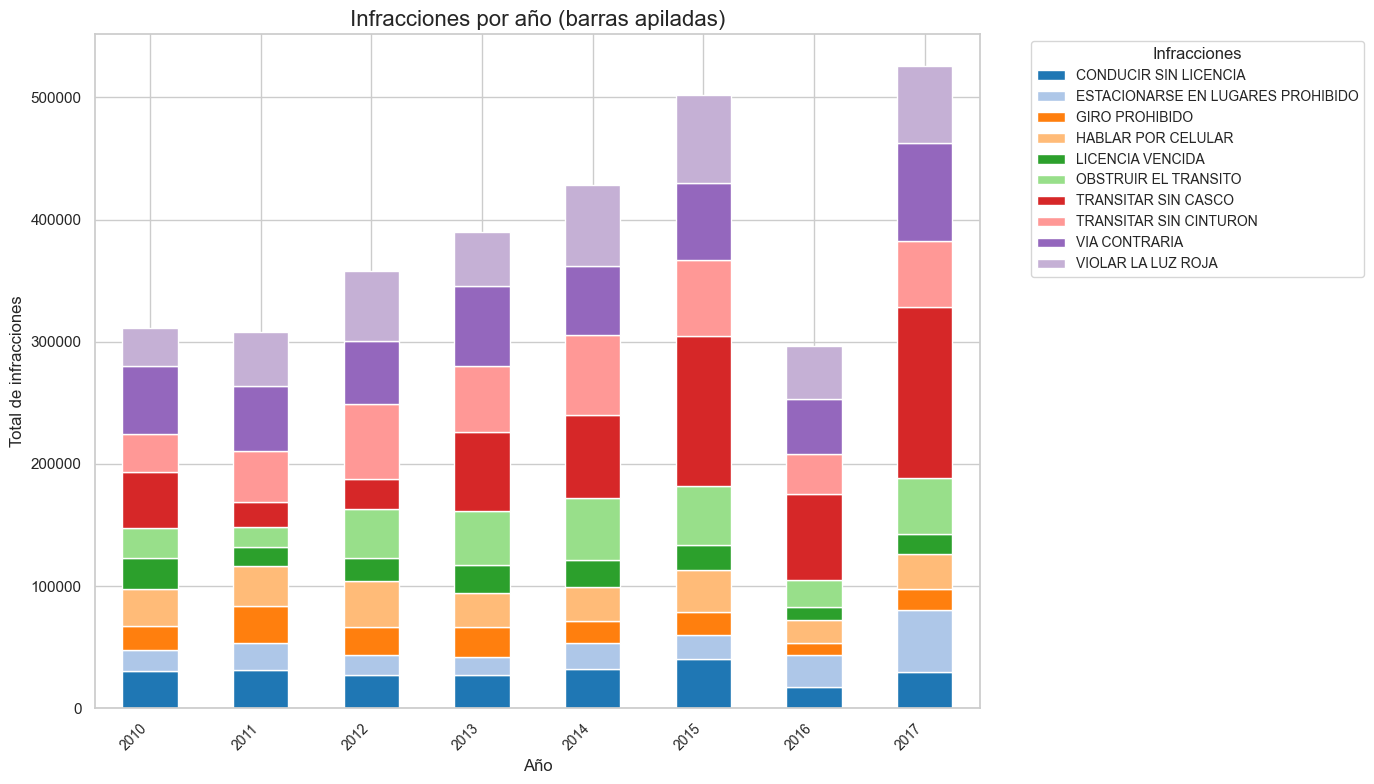

In [79]:
# Hago pivot table del DataFrame para que los años sean el índice y las infracciones sean las columnas
df_pivot = df_infracciones_1.pivot_table(
    index='anio', 
    columns='infracciones', 
    values='total', 
    aggfunc='sum'
)

# Creo el gráfico de barras apiladas
df_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=plt.cm.tab20.colors  # Colores para las infracciones
)

# Personalizo el gráfico
plt.title('Infracciones por año (barras apiladas)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Total de infracciones', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Infracciones', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [80]:
df_infracciones_1['infracciones'] = df_infracciones_1['infracciones'].str.strip().str.lower()
df_infracciones_1['infracciones'].unique()

array(['violar la luz roja', 'transitar sin casco',
       'transitar sin cinturon', 'hablar por celular', 'via contraria',
       'licencia vencida', 'conducir sin licencia',
       'obstruir el transito', 'estacionarse en lugares prohibido',
       'giro prohibido'], dtype=object)

In [81]:
df_infracciones_1= df_infracciones_1[['anio', 'infracciones', 'total', 'porcentaje']]

In [82]:
df_infracciones_1['infracciones'] = df_infracciones_1['infracciones'].replace({
    'estacionarse en lugares prohibido': 'estacionarse en lugares prohibidos'})

In [83]:
df_infracciones_1['infracciones'] = df_infracciones_1['infracciones'].replace({
    'licencia vencida': 'conducir sin licencia y/o vencida', 
    'conducir sin licencia': 'conducir sin licencia y/o vencida'})

### Segundo conjunto de datos - infracciones del 2018 en adelante

In [84]:
# Calculo el porcentaje dentro de cada año usando transform
df_infracciones_2['porcentaje'] = df_infracciones_2.groupby('anio')['total'].transform(lambda x: (x / x.sum()) * 100)

# Verifico los resultados
df_infracciones_2 = df_infracciones_2[['anio', 'infracciones', 'total', 'porcentaje']]

In [85]:
# Quito elementos que no sean texto
df_infracciones_2['infracciones'] = df_infracciones_2['infracciones'].str.replace(
    r'^\d+\.?\s*|\(.*?\)', '', regex=True
).str.strip()

In [86]:
df_infracciones_2['porcentaje'] = df_infracciones_2['porcentaje'].round(2)

In [87]:
df_infracciones_2['infracciones']=df_infracciones_2['infracciones'].str.replace('-', '')

In [88]:
df_infracciones_2['infracciones'] = df_infracciones_2['infracciones'].str.lower()
df_infracciones_2.head()

,anio,infracciones,total,porcentaje
0,2018,transitar sin tablilla,527,0.06
1,2018,exceso de pasajeros,4153,0.51
2,2018,niños en el asiento delantero,2601,0.32
3,2018,pasajeros en vehículos de carga,11393,1.40
4,2018,violar señales de tránsito,12044,1.48


In [89]:
mapeo_multiple = {
    # Estacionarse en lugares prohibidos
    'estacionarse en lugar prohibido': 'estacionarse en lugares prohibidos',
    'estacionarse en lugares prohibido': 'estacionarse en lugares prohibidos',
    'estacionarse en lugares prohibidos': 'estacionarse en lugares prohibidos',
    
    # Obstruir el tránsito
    'parar en la intersecciones / obstruir el tránsito': 'obstruir el transito',
    'obstruir el tránsito': 'obstruir el transito',
    
    # Conducir sin licencia y/o vencida
    'transitar sin licencia y/o vencida': 'conducir sin licencia y/o vencida',
    'transitar sin permiso': 'conducir sin licencia y/o vencida',
    'conducir sin licencia': 'conducir sin licencia y/o vencida',
    'licencia vencida': 'conducir sin licencia y/o vencida',
    'transitar sin licencia o vencida': 'conducir sin licencia y/o vencida',
    
    # Vía contraria
    'transitar en vía contraria': 'via contraria',
    'vía contraria': 'via contraria',
    
    # Hablar por celular
    'uso de celular o dispositivos electrónicos': 'hablar por celular',
    'uso del celular o dispositivos electrónicos  art. 221)': 'hablar por celular',
    
    # Transitar sin cinturón
    'transitar sin cinturón': 'transitar sin cinturon',
    'no uso del cinturón de seguridad': 'transitar sin cinturon',
    
    # Transitar sin casco
    'transitar sin casco protector': 'transitar sin casco',
    'no uso del casco protector': 'transitar sin casco',
    
    # Violar la luz roja
    'violar luz roja': 'violar la luz roja',
    'respeto a las señales del semáforo': 'violar la luz roja',
    
    # Giro prohibido
    'realizar giro prohibido': 'giro prohibido'
}


In [90]:
df_infracciones_2['infracciones'] = df_infracciones_2['infracciones'].str.strip()
df_infracciones_2 = f.reemplazar_valores(
    dataframe=df_infracciones_2, 
    columna='infracciones', 
    mapeo=mapeo_multiple
)

In [91]:
# Lista de infracciones válidas
infracciones_validas = ['violar la luz roja', 'transitar sin casco',
       'transitar sin cinturon', 'hablar por celular', 'via contraria',
       'conducir sin licencia y/o vencida',
       'obstruir el transito', 'estacionarse en lugares prohibidos',
       'giro prohibido']

# Convierto todas las infracciones que no están en la lista a 'otros'
df_infracciones_2['infracciones'] = df_infracciones_2['infracciones'].apply(
    lambda x: x if x in infracciones_validas else 'otros'
)

In [92]:
df_infracciones_2[df_infracciones_2['anio'] == 2023].sort_values(by='porcentaje', ascending=False).head(10)

,anio,infracciones,total,porcentaje
528,2023,transitar sin casco,370528,24.65
460,2023,violar la luz roja,147291,9.80
536,2023,otros,135340,9.00
500,2023,otros,114846,7.64
499,2023,conducir sin licencia y/o vencida,113053,7.52
511,2023,transitar sin cinturon,89945,5.98
541,2023,otros,45188,3.01
530,2023,via contraria,43754,2.91
503,2023,hablar por celular,41102,2.73
480,2023,otros,40679,2.71


In [93]:
pivot_infracciones_2 = f.crear_tabla_pivote(df_infracciones_2, values='total', index='infracciones', columns='anio', aggfunc='sum')
pivot_infracciones_2['total'] = pivot_infracciones_2.sum(axis=1)
pivot_infracciones_2.reset_index(inplace=True)
total_pivot_2 = pivot_infracciones_2['total'].sum()
pivot_infracciones_2['porcentaje'] = (pivot_infracciones_2['total']/total_pivot_2) * 100
pivot_infracciones_2.sort_values(by='porcentaje', ascending=False)

anio,infracciones,2018,2019,2020,2021,2022,2023,2024,total,porcentaje
5,otros,244116,378623,211748,541612,815832,606239,745982,3544152,37.58
6,transitar sin casco,209670,248639,178142,395468,447986,370528,573078,2423511,25.70
9,violar la luz roja,61911,72103,60072,160381,178461,147291,150901,831120,8.81
0,conducir sin licencia y/o vencida,66437,87558,35822,104497,172724,113053,173281,753372,7.99
7,transitar sin cinturon,72964,57569,31555,100229,144291,89945,103156,599709,6.36
3,hablar por celular,30882,31518,16156,51606,72092,41102,42829,286185,3.03
8,via contraria,33762,30046,21901,39215,58488,43754,50415,277581,2.94
1,estacionarse en lugares prohibidos,38677,40940,25404,42059,45144,33419,45133,270776,2.87
2,giro prohibido,24103,28875,14730,41623,48219,31565,34891,224006,2.38
4,obstruir el transito,30408,27981,19278,45511,42895,26522,28572,221167,2.34


<Axes: xlabel='anio', ylabel='total'>

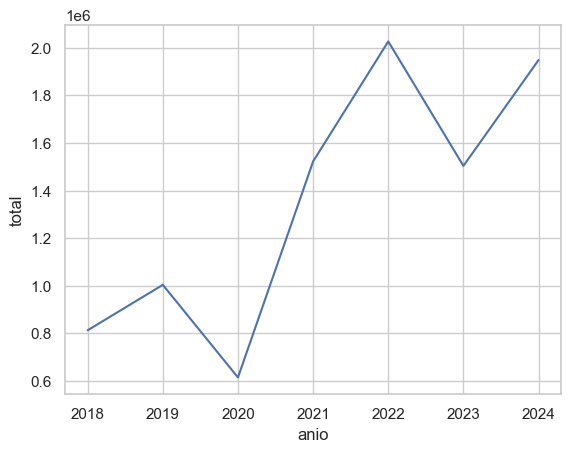

In [94]:
total_infraciones_2 = df_infracciones_2.groupby('anio')['total'].sum().reset_index()
sns.lineplot(x='anio', y='total', data=total_infraciones_2)

In [95]:
df_infracciones_total = pd.concat([df_infracciones_1, df_infracciones_2], ignore_index=True)
df_infracciones_total.head()

,anio,infracciones,total,porcentaje
0,2010,violar la luz roja,31531,10.13
1,2010,transitar sin casco,45466,14.60
2,2010,transitar sin cinturon,31331,10.06
3,2010,hablar por celular,29876,9.59
4,2010,via contraria,38764,12.45


<Axes: xlabel='anio', ylabel='total'>

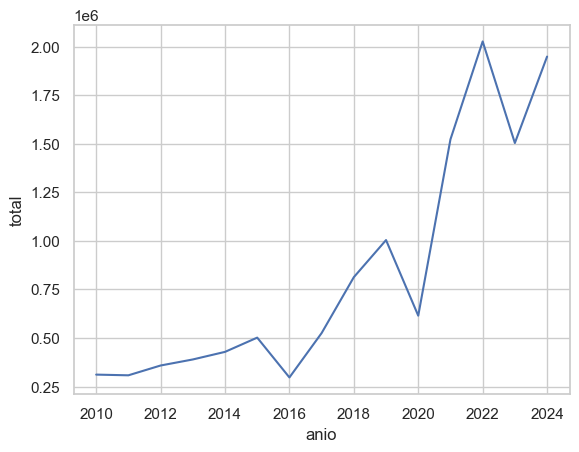

In [96]:
total_infraciones__full = df_infracciones_total.groupby('anio')['total'].sum().reset_index()
sns.lineplot(x='anio', y='total', data=total_infraciones__full)

In [97]:
df_infracciones_total.drop(columns='porcentaje', inplace=True)

In [98]:
df_infracciones_total.to_csv('../Datos/infracciones/df_infracciones_completo.csv')

In [99]:
df_infracciones_total.groupby('infracciones')['total'].sum().reset_index().sort_values(by='total', ascending=False)

,infracciones,total
5,otros,3544152
6,transitar sin casco,2978662
9,violar la luz roja,1253059
0,conducir sin licencia y/o vencida,1142576
7,transitar sin cinturon,1003650
8,via contraria,746825
3,hablar por celular,524553
4,obstruir el transito,513335
1,estacionarse en lugares prohibidos,458208
2,giro prohibido,385689


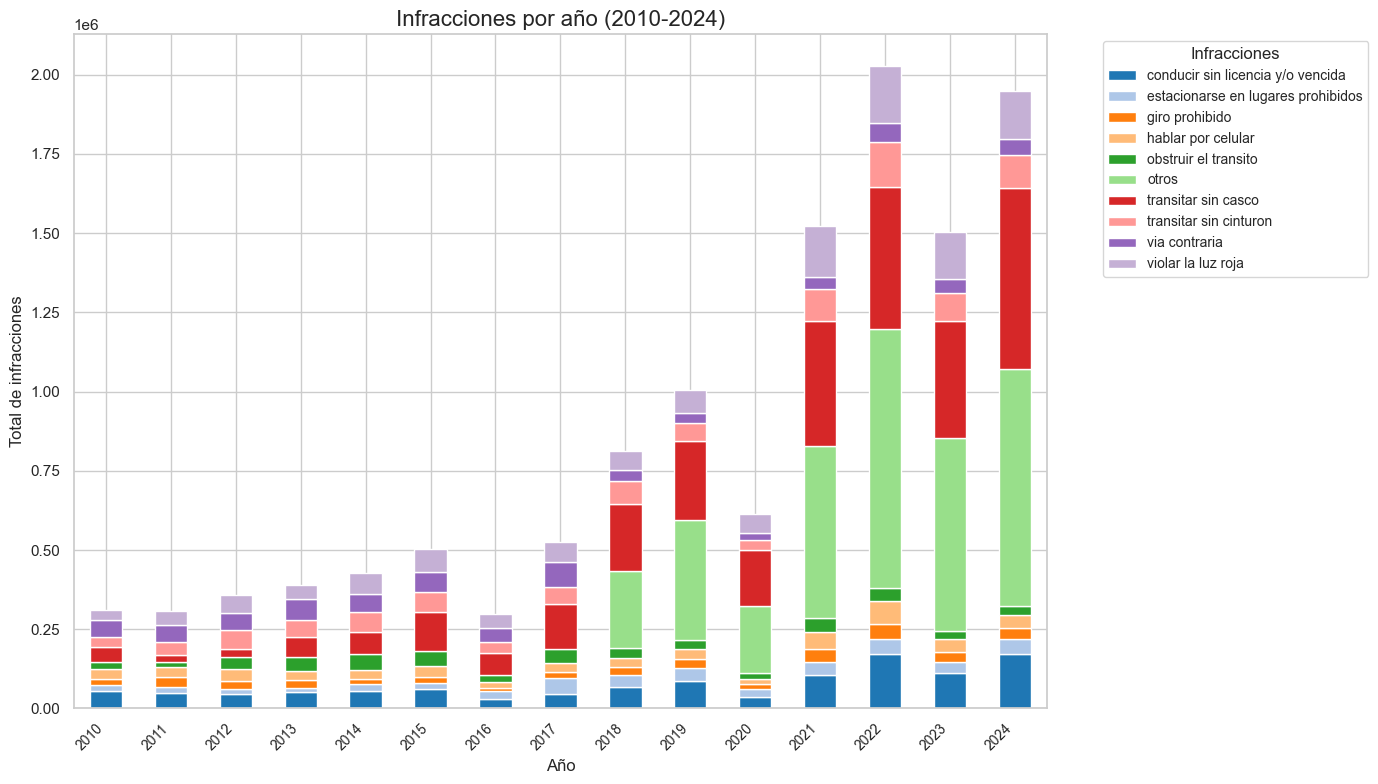

In [100]:
# Hago pivot table del DataFrame para que los años sean el índice y las infracciones sean las columnas
df_pivot_total = df_infracciones_total.pivot_table(
    index='anio', 
    columns='infracciones', 
    values='total', 
    aggfunc='sum'
)

# Creo el gráfico de barras apiladas
df_pivot_total.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=plt.cm.tab20.colors  # Colores para las infracciones
)

plt.title('Infracciones por año (2010-2024)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Total de infracciones', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Infracciones', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()